# ARUCO markers 

## 1:  Marker creation

<IPython.core.display.Javascript object>


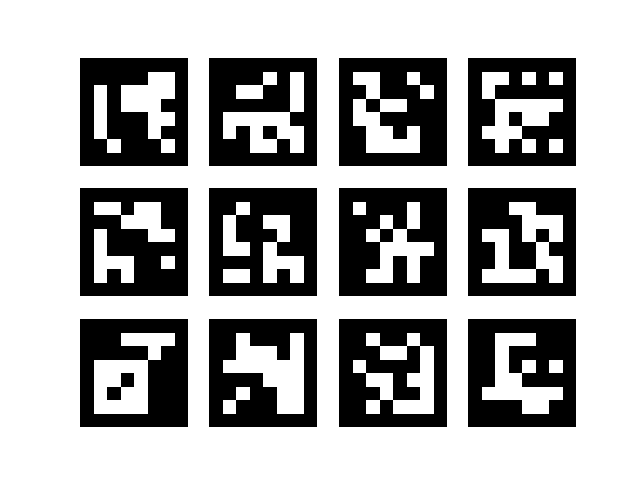

In [2]:
import numpy as np
import cv2, PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

fig = plt.figure()
nx = 4
ny = 3
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig("markers.pdf")    
plt.show()


## Print, cut, stick and take a picture

<IPython.core.display.Javascript object>


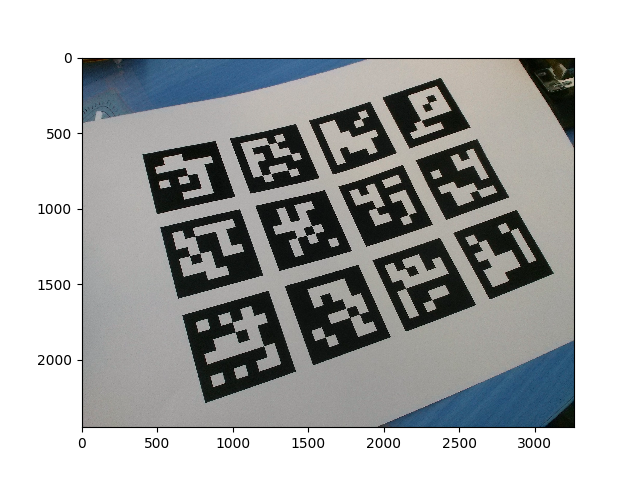

In [5]:
frame = cv2.imread("data/aruco_photo.jpg")
plt.figure()
plt.imshow(frame)
plt.show()

## Post processing

In [6]:
%%time
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)


CPU times: user 316 ms, sys: 112 ms, total: 428 ms
Wall time: 168 ms


Very fast processing !

## Results

<IPython.core.display.Javascript object>


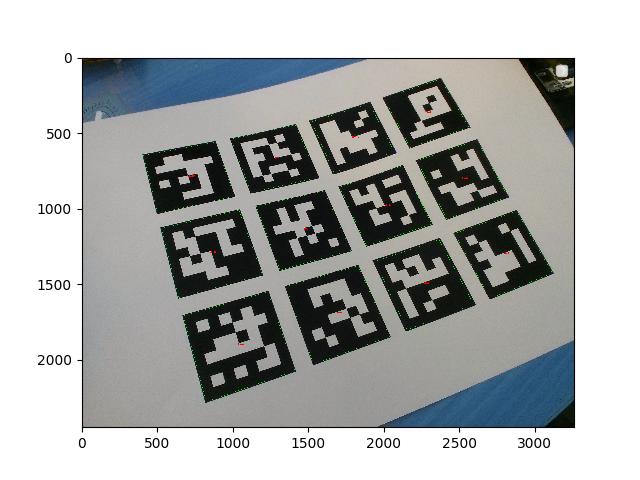

No handles with labels found to put in legend.


In [7]:
plt.figure()
plt.imshow(frame_markers)
"""for i in range(len(ids)):
    c = corners[i][0]
    #plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
"""
plt.legend()
plt.show()

In [7]:
def quad_area(data):
    l = data.shape[0]//2
    corners = data[["c1", "c2", "c3", "c4"]].values.reshape(l, 2,4)
    c1 = corners[:, :, 0]
    c2 = corners[:, :, 1]
    c3 = corners[:, :, 2]
    c4 = corners[:, :, 3]
    e1 = c2-c1
    e2 = c3-c2
    e3 = c4-c3
    e4 = c1-c4
    a = -.5 * (np.cross(-e1, e2, axis = 1) + np.cross(-e3, e4, axis = 1))
    return a

corners2 = np.array([c[0] for c in corners])

data = pd.DataFrame({"x": corners2[:,:,0].flatten(), "y": corners2[:,:,1].flatten()},
                   index = pd.MultiIndex.from_product( 
                           [ids.flatten(), ["c{0}".format(i )for i in np.arange(4)+1]], 
                       names = ["marker", ""] ))

data = data.unstack().swaplevel(0, 1, axis = 1).stack()
data["m1"] = data[["c1", "c2"]].mean(axis = 1)
data["m2"] = data[["c2", "c3"]].mean(axis = 1)
data["m3"] = data[["c3", "c4"]].mean(axis = 1)
data["m4"] = data[["c4", "c1"]].mean(axis = 1)
data["o"] = data[["m1", "m2", "m3", "m4"]].mean(axis = 1)
stats = pd.DataFrame({"Area": quad_area(data)}, index = data.unstack().index)
stats

,Area
marker,
1,4101.0
2,4027.5
3,1338.0
4,1652.5
5,1389.0
6,1475.0
7,1285.0
8,1302.0
9,1336.5


## Camera calibration

Creation of an Aruco chessboard calibration pattern (Charuco).

<IPython.core.display.Javascript object>


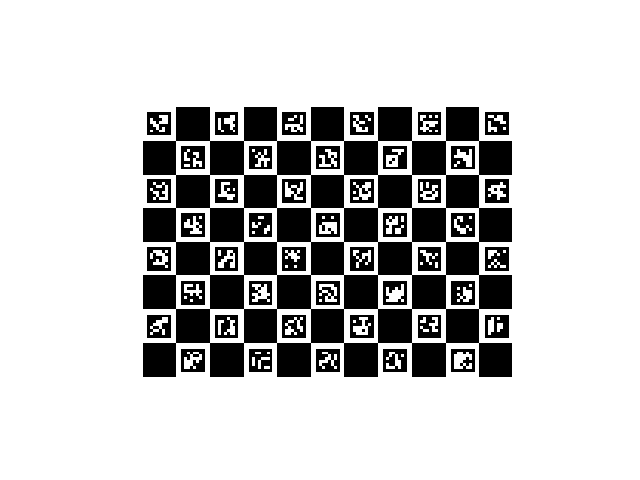

In [8]:
board = aruco.CharucoBoard_create(11, 8, 10, 7, aruco_dict)
imboard = board.draw((500, 500))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.savefig("chessboard.pdf")    
plt.show()


In [9]:
def calibrate_camera():
    allCorners = []
    allIds = []
    decimator = 0
    for i in range(1, 5):
        frame = cv2.imread("chessboard_00{0}.jpg".format(i))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        res = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(res[0])>0:
            res2 = cv2.aruco.interpolateCornersCharuco(res[0],res[1],gray,board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%3==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])

            cv2.aruco.drawDetectedMarkers(gray,res[0],res[1])

        decimator+=1

    imsize = gray.shape

    ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors = cv2.aruco.calibrateCameraCharuco(allCorners,allIds,board,imsize,None,None)
    #aruco.estimatePoseSingleMarkers(corners, 0.05, mtx, dist, rvecs[0], tvecs[0])
    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [12]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()
mtx

array([[  3.17589042e+03,   0.00000000e+00,   1.16428527e+03],
       [  0.00000000e+00,   3.18521002e+03,   1.49663291e+03],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [95]:
imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[0], tvecs[0], 0.1)

<IPython.core.display.Javascript object>


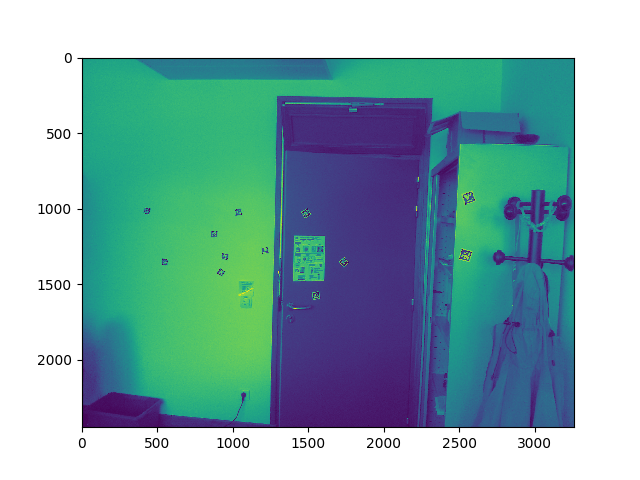

In [98]:
plt.figure()
plt.imshow(imaxis)
plt.show()